**Описание**:

Целью проекта является проведение анализа жанров художественных книг и их  литературной ценности, измеряемой с помощью агрегированных пользовательских оценок на платформе Goodreads.

Для этого с сайта Goodreads с помощью Selenium будет собран датасет, включающий следующие поля:

- название книги
- авторы
- жанры
- средняя пользовательская оценка
- количество оценок
- количество страниц

Источник данных — книги на Goodreads из списка «Best Books Ever».

Суть исследования:
Выполнен статистический анализ собранных данных, направленный на неопределенность:

- какие жанры получают более высокую оценку пользователей
- существует ли зависимость между количеством страниц и рейтингом
- какие жанры влияют на рейтинг
- какие авторы стабильно получают высокие рейтинги

Акцент делается на анализе книг с учетом аудитории в качестве индикатора ее ценности. Полученные результаты будут визуализированы и проанализированы с помощью pandas.

In [100]:
import csv
import logging
import os
import re
import sys
import warnings
from typing import Optional, Union

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait

# Загрузка данных

In [35]:
# ---------------------- Константы ----------------------

BOOKS_URL = "https://www.goodreads.com/list/show/1.Best_Books_Ever"
BOOK_DETAILS_URL = "https://www.goodreads.com/book/show/{book_id}/"

BOOK_PAGE_SELECTOR = 'h1[data-testid="bookTitle"]'
GENRE_SELECTOR = "span.BookPageMetadataSection__genreButton"
AUTHOR_SELECTOR = "span.ContributorLink__name"
RATING_SELECTOR = "div.RatingStatistics__rating"
RATING_META_SELECTOR = "div.RatingStatistics__meta"
SHOW_MORE_XPATH = "//button[@aria-label='Show all items in the list']"
TAG_P = "p"
BOOK_LINK_SELECTOR = "a.bookTitle"

USER_AGENT = (
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
    "(KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36"
)

CSV_FIELDNAMES = ["title", "author", "rating", "genres", "pages", "ratings_count"]
OUTPUT_CSV_PATH = "data/db.csv"
# ---------------------- Логгирование ----------------------

logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s:  %(name)s, %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
)
logger = logging.getLogger("goodreads-scraper")

# ---------------------- Инициализация драйвера ----------------------

def init_driver(headless: bool = True) -> webdriver.Chrome:
    options = webdriver.ChromeOptions()
    if headless:
        options.add_argument("--headless=new")
    options.add_argument("--window-size=1920,1080")
    options.add_argument("--disable-gpu")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument(f"user-agent={USER_AGENT}")
    return webdriver.Chrome(options=options)


# ---------------------- Вспомогательные функции ----------------------

def safe_get_text(
    driver: webdriver.Chrome,
    by: By,
    selector: str,
    attr: str = "text",
    multiple: bool = False,
) -> Union[Optional[str], list[str]]:
    try:
        elements = driver.find_elements(by, selector) if multiple else [driver.find_element(by, selector)]

        if attr == "text":
            if multiple:
                return [el.text.strip() for el in elements if el.text.strip()]
            return elements[0].text.strip()

        if multiple:
            return [el.get_attribute(attr) for el in elements if el.get_attribute(attr)]
        return elements[0].get_attribute(attr)

    except Exception:
        return [] if multiple else None


def wait_scroll_and_expand(driver: webdriver.Chrome) -> None:
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, BOOK_PAGE_SELECTOR))
    )
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    WebDriverWait(driver, 5).until(
        lambda d: d.execute_script("return document.readyState") == "complete"
    )
    try:
        more_button = WebDriverWait(driver, 3).until(
            EC.element_to_be_clickable((By.XPATH, SHOW_MORE_XPATH))
        )
        driver.execute_script("arguments[0].click();", more_button)
    except Exception as error:
        logger.warning(f"Не удалось развернуть список жанров: {str(error)}")


# ---------------------- Основной парсинг книги ----------------------

def get_goodreads_book_data(driver: webdriver.Chrome, url: str) -> dict:
    try:
        driver.get(url)
        wait_scroll_and_expand(driver)

        genres = safe_get_text(driver, By.CSS_SELECTOR, GENRE_SELECTOR, multiple=True)
        title = safe_get_text(driver, By.CSS_SELECTOR, BOOK_PAGE_SELECTOR)
        authors = safe_get_text(driver, By.CSS_SELECTOR, AUTHOR_SELECTOR, multiple=True)
        author = ", ".join(authors) if authors else ""
        rating = float(safe_get_text(driver, By.CSS_SELECTOR, RATING_SELECTOR))
        rating_text = safe_get_text(driver, By.CSS_SELECTOR, RATING_META_SELECTOR)
        ratings_count = int(rating_text.split("ratings")[0].strip().replace(",", ""))

        pages = None
        p_tags = driver.find_elements(By.TAG_NAME, TAG_P)
        for p in p_tags:
            text = p.text.strip().lower()
            if "pages" in text:
                pages = int(text.split()[0])
                break

        return {
            "title": title,
            "author": author,
            "rating": rating,
            "genres": genres,
            "pages": pages,
            "ratings_count": ratings_count,
        }

    except Exception as error:
        logger.warning(f"Ошибка при обработке {url}: {error}")
        return {}


def get_top_goodreads_book_ids(driver: webdriver.Chrome, max_books: int = 100) -> list[int]:
    book_ids = []
    page = 1

    while len(book_ids) < max_books:
        driver.get(f"{BOOKS_URL}?page={page}")
        WebDriverWait(driver, 10).until(
            lambda d: d.execute_script("return document.readyState") == "complete"
        )

        links = driver.find_elements(By.CSS_SELECTOR, BOOK_LINK_SELECTOR)

        for link in links:
            href = link.get_attribute("href")
            if "/book/show/" in href:
                book_id_part = href.split("/book/show/")[1].split(".")[0]
                if book_id_part.isdigit() and int(book_id_part) not in book_ids:
                    book_ids.append(int(book_id_part))
                    if len(book_ids) >= max_books:
                        break

        logger.info(f"Страница {page} обработана, всего ID: {len(book_ids)}")
        page += 1

    return book_ids

# ---------------------- Основная функция ----------------------

def main() -> None:
    output_path = os.path.abspath(os.path.join("..", OUTPUT_CSV_PATH))
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    logger.info(f"CSV-файл будет сохранён в: {output_path}")

    with open(output_path, mode="w", encoding="utf-8", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=CSV_FIELDNAMES)
        writer.writeheader()

        driver = init_driver(headless=True)
        ids = get_top_goodreads_book_ids(driver, 500)
        logger.info(f"Получено {len(ids)} книг")

        for i, book_id in enumerate(ids, 1):
            url = BOOK_DETAILS_URL.format(book_id=book_id)
            logger.info(f"[{i}/{len(ids)}] Обрабатываем: {url}")

            info = get_goodreads_book_data(driver, url)
            if isinstance(info.get("genres"), list):
                info["genres"] = ", ".join(info["genres"])

            writer.writerow(info)
            file.flush()
            logger.info(f"Книга '{info.get('title')}' добавлена в CSV")

        driver.quit()
# -------------------------------------------------------------

In [37]:
main()

INFO:  goodreads-scraper, CSV-файл будет сохранён в: c:\Dev\books\data\db.csv
INFO:  goodreads-scraper, Страница 1 обработана, всего ID: 82
INFO:  goodreads-scraper, Страница 2 обработана, всего ID: 153
INFO:  goodreads-scraper, Страница 3 обработана, всего ID: 209
INFO:  goodreads-scraper, Страница 4 обработана, всего ID: 276
INFO:  goodreads-scraper, Страница 5 обработана, всего ID: 340
INFO:  goodreads-scraper, Страница 6 обработана, всего ID: 406
INFO:  goodreads-scraper, Страница 7 обработана, всего ID: 455
INFO:  goodreads-scraper, Страница 8 обработана, всего ID: 500
INFO:  goodreads-scraper, Получено 500 книг
INFO:  goodreads-scraper, [1/500] Обрабатываем: https://www.goodreads.com/book/show/2/
INFO:  goodreads-scraper, Книга 'Harry Potter and the Order of the Phoenix' добавлена в CSV
INFO:  goodreads-scraper, [2/500] Обрабатываем: https://www.goodreads.com/book/show/1885/
INFO:  goodreads-scraper, Книга 'Pride and Prejudice' добавлена в CSV
INFO:  goodreads-scraper, [3/500] Об

## Очистка данных и подготовка к анализу

In [104]:
warnings.filterwarnings("ignore")
logging.getLogger('matplotlib.category').setLevel(logging.ERROR)

DATA_PATH = "../data/db.csv"
df = pd.read_csv(DATA_PATH)

print("Размер датасета:", df.shape)
df.head()

Размер датасета: (500, 6)


,title,author,rating,genres,pages,ratings_count
0,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré, J.K. Rowling",4.50,"Fantasy, Young Adult, Fiction, Magic, Audioboo...",912.0,3648248.0
1,Pride and Prejudice,"Jane Austen, Anna Quindlen, Jane Austen, Natal...",4.29,"Classics, Romance, Fiction, Historical Fiction...",279.0,4560030.0
2,To Kill a Mockingbird,"Harper Lee, Harper Lee",4.26,"Historical Fiction, School, Literature, Young ...",323.0,6606121.0
3,The Book Thief,"Markus Zusak, Markus Zusak",4.39,"Historical Fiction, Fiction, Young Adult, Clas...",592.0,2769466.0
4,Twilight,"Stephenie Meyer, Stephenie Meyer",3.67,"Fantasy, Young Adult, Romance, Fiction, Vampir...",498.0,7052742.0


In [90]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    "Количество пропусков": missing,
    "Процент": missing_percent.round(2)
})
missing_df = missing_df[missing_df["Количество пропусков"] > 0].sort_values(by="Процент", ascending=False)

display(missing_df)

,Количество пропусков,Процент
title,2,0.4
author,2,0.4
rating,2,0.4
genres,2,0.4
pages,2,0.4
ratings_count,2,0.4


In [91]:
df = df.dropna(subset=["title", "author", "rating", "genres", "pages", "ratings_count"]).copy()

In [92]:
duplicate_count = df.duplicated().sum()
print(f"Дубликатов: {duplicate_count}")

df = df.drop_duplicates().copy()


Дубликатов: 1


In [94]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

df["pages"] = pd.to_numeric(df["pages"], errors="coerce").astype("Int64")
df["ratings_count"] = pd.to_numeric(df["ratings_count"], errors="coerce").astype("Int64")
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

print("\nИнформация о типах данных:")
print(df.dtypes)



Информация о типах данных:
title             object
author            object
rating           float64
genres            object
pages              Int64
ratings_count      Int64
dtype: object


# Анализ и визуализация

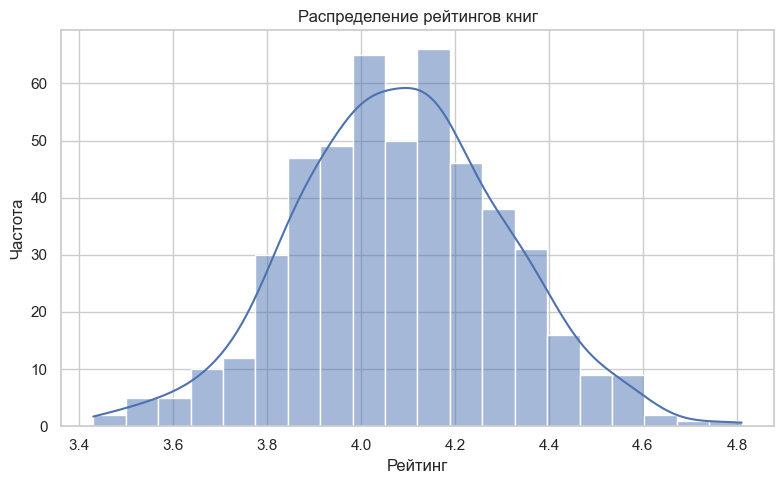

In [102]:
plt.figure(figsize=(8, 5))
sns.histplot(df["rating"], bins=20, kde=True)
plt.title("Распределение рейтингов книг")
plt.xlabel("Рейтинг")
plt.ylabel("Частота")
plt.grid(True)
plt.tight_layout()
plt.show()

- Распределение близко к нормальному
- Большинство книг получили рейтинги от 3.8 до 4.3, что указывает на:
    - высокую общую оценку произведений в выборке
    - положительный сдвиг восприятия книг на Goodreads
- Практически нет книг с оценками ниже 3.5, что может быть связано с:
    - отсутствие некачественного контента в выборке
    - пользовательским уклоном в сторону положительных отзывов

Вывод: Пользователи в среднем положительно оценивают книги. Данные хорошо подходят для анализа трендов, связанных с жанрами, объёмом и авторами

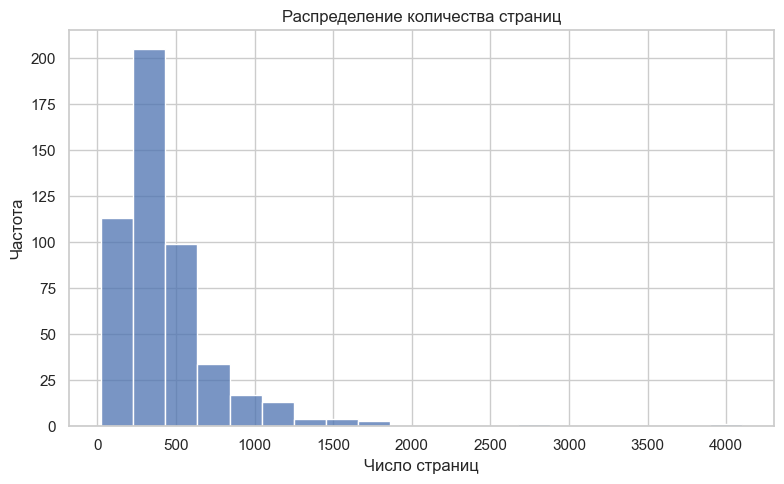

In [103]:
plt.figure(figsize=(8, 5))
sns.histplot(df["pages"].dropna(), bins=20)
plt.title("Распределение количества страниц")
plt.xlabel("Число страниц")
plt.ylabel("Частота")
plt.grid(True)
plt.tight_layout()
plt.show()

- Распределение сильно смещено вправо, подавляющее большинство книг имеют объём до 600 страниц
- Основной корпус книг укладывается в диапазон 200–600 страниц, что соответствует стандартным ожиданиям читателей

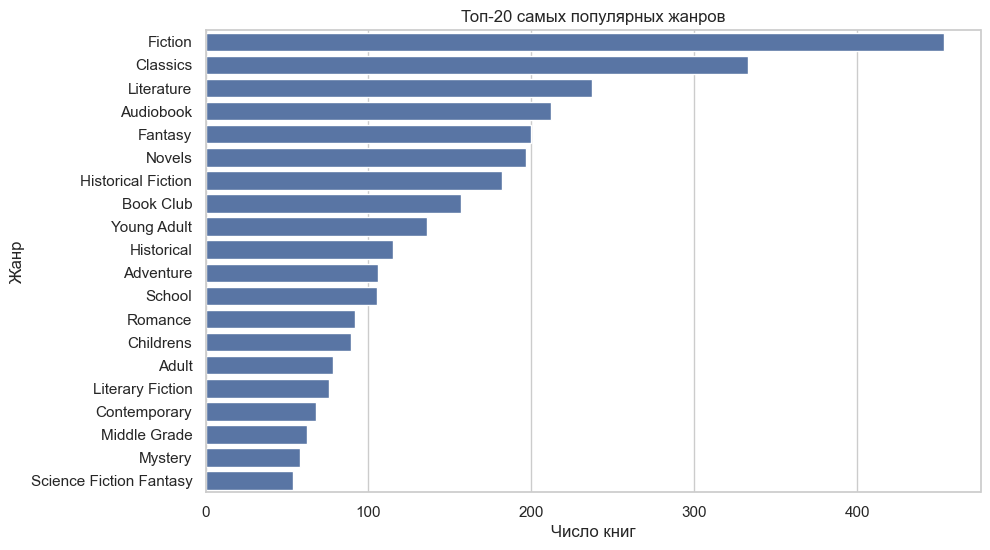

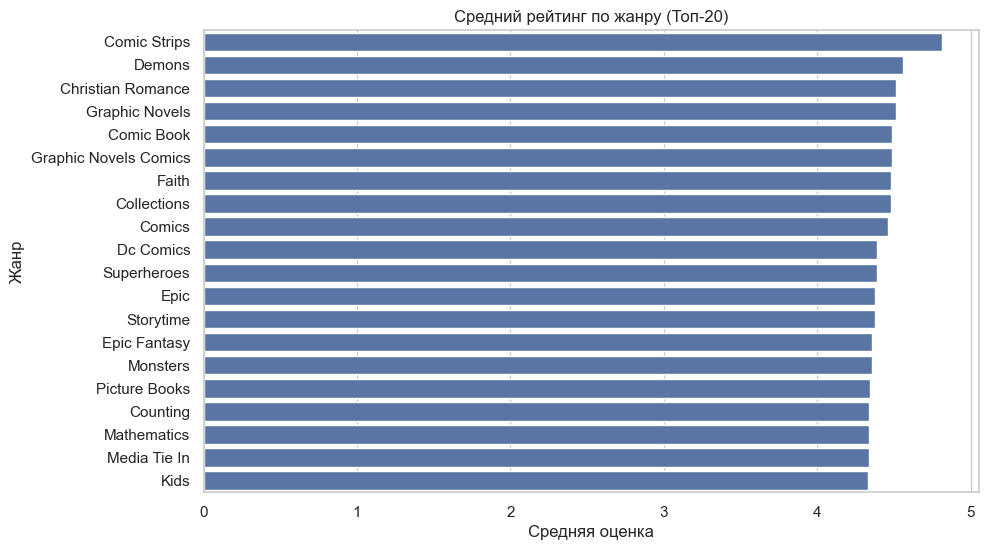

In [99]:
df["genres_list"] = df["genres"].apply(lambda x: [g.strip() for g in str(x).split(",")])
df_exploded = df.explode("genres_list").rename(columns={"genres_list": "genre"})

genre_counts = df_exploded["genre"].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(y=genre_counts.index, x=genre_counts.values)
plt.title("Топ-20 самых популярных жанров")
plt.xlabel("Число книг")
plt.ylabel("Жанр")
plt.show()

genre_rating = (
    df_exploded.groupby("genre")["rating"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_rating.values, y=genre_rating.index)
plt.title("Средний рейтинг по жанру (Топ-20)")
plt.xlabel("Средняя оценка")
plt.ylabel("Жанр")
plt.show()


- Абсолютным лидеров является вымысел, что ожидаемо, тк этот жанр дает большое простраство автору для сюжета
- Далее следуют жанры классику и литературу, что отражает популярность классической художественной сцены
- В нижней части топа — мистика, средний класс, научная фантастическая фентези, что может говорить о ограниченной массовой аудитории

- Жанры, связанные с комиксами, такие как Комиксы, графические романы, супергерои, — занимают лидирующие позиции по средней оценке
- Высокие оценки также у нишевых категорий: христианская романтика, Вера, математика, эпическое фэнтези это может указывать на узкую, но целевую направленность, где книги подбираются строго по интересам
- Также жанры с высоким рейтингом не пересекаются с жанрами, которые чаще всего встречаются — т.е. популярность ≠ качество по мнению читателей

Гипотеза: чем больше жанров у книги, тем она универсальнее => выше/ниже рейтинг
Альтернативная гипотеза: количество жанров книги не зависит на рейтинг книги

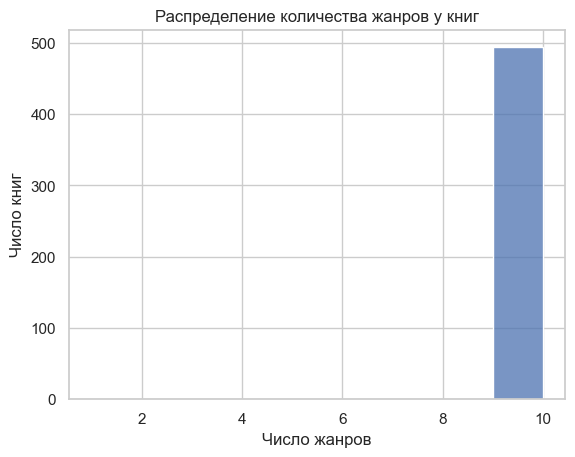

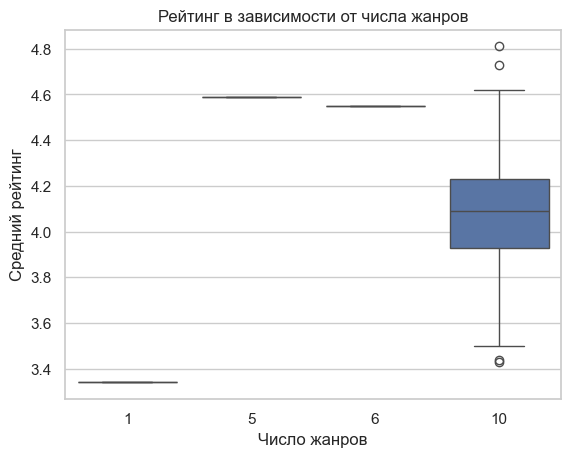

In [96]:
df["n_genres"] = df["genres_list"].apply(len)

sns.histplot(df["n_genres"], bins=range(1, df["n_genres"].max() + 1), kde=False)
plt.title("Распределение количества жанров у книг")
plt.xlabel("Число жанров")
plt.ylabel("Число книг")
plt.show()

sns.boxplot(x="n_genres", y="rating", data=df)
plt.title("Рейтинг в зависимости от числа жанров")
plt.xlabel("Число жанров")
plt.ylabel("Средний рейтинг")
plt.show()


Почти у всех книг по 10 жанров, значит выполняется альтернативная гипотеза, что количество жанров книги не зависит на рейтинг книги

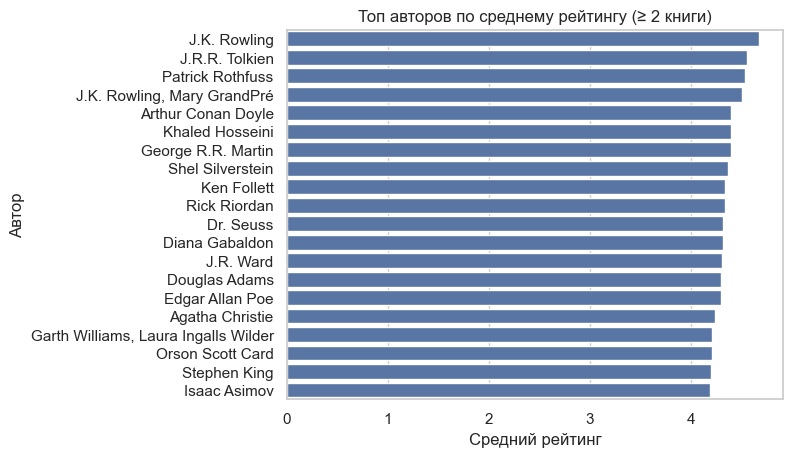

In [97]:
def dedup_author_names(author):
    return ", ".join(sorted(set(name.strip() for name in author.split(","))))

def is_latin_only(name):
    return bool(re.search(r"[a-zA-Z]", name))

df = df[df["author"].apply(is_latin_only)]
df["author_clean"] = df["author"].apply(dedup_author_names)

author_stats = (
    df.groupby("author_clean")
    .agg(n_books=("title", "count"), avg_rating=("rating", "mean"))
    .query("n_books >= 2")
    .sort_values(by="avg_rating", ascending=False)
    .head(20)
)


sns.barplot(x=author_stats["avg_rating"], y=author_stats.index)
plt.title("Топ авторов по среднему рейтингу (≥ 2 книги)")
plt.xlabel("Средний рейтинг")
plt.ylabel("Автор")
plt.show()


- J.K. Rowling и J.R.R. Tolkien возглавляют рейтинг, что подтверждает устойчивую популярность и высокую оценку фэнтезийных вселенных у широкой аудитории
- В топ-5 входят также Patrick Rothfuss, J.K. Rowling, Mary GrandPré и Arthur Conan Doyle, что демонстрирует интерес читателей к эпическим историям и классическим детективам
- Khaled Hosseini, George R.R. Martin, Ken Follett и Rick Riordan также показывают стабильное качество по мнению читателей — их книги регулярно получают высокие оценки
- Среди топовых авторов присутствуют как современные писатели, так и классики: Agatha Christie, Isaac Asimov, Stephen King, Edgar Allan Poe
- Отдельного внимания заслуживает включение авторов детской литературы — например, Shel Silverstein и Dr. Seuss, что подчёркивает высокую вовлечённость и лояльность их читательской аудитории

Книги с устойчиво высоким рейтингом пишут как авторы массовой литературы, так и классики жанров. Это говорит о том, что качество литературного произведения не обязательно связано с жанром или временем написания — читатели ценят хорошо проработанные истории и стиль

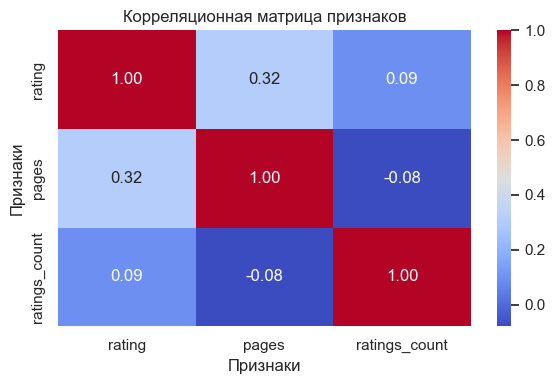

In [98]:
corr_df = df[["rating", "pages", "ratings_count"]].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица признаков")
plt.xlabel("Признаки")
plt.ylabel("Признаки")
plt.tight_layout()
plt.show()

- Есть слабая зависимость между рейтингом и количество страниц 0.32, говорит о том что долгие истории могут цеплять чуть дольше так как читатель не уъодит из мира книги
- Между рейтингом и количеством отзывов есть очень слабая связь 0.092, что значит популярность книги не обязательно обеспечивает ей всеобщее признание

Между признаками нет сильной зависимости, что подчеркивает субъективность литературной оценки и важность немеряемых факторов: стиля, сюжета и тд

# Выводы

- Самые популярные жанры среди представленных книг — это художественная литература и классика, что подчёркивает интерес аудитории к проверенной временем художественной прозе
- Самые высокие рейтинги получают книги в жанрах комиксы, графические романы, христианская романтика — это говорит о высокой вовлечённости фанатских и нишевых сообществ, которые целенаправленно читают и оценивают узкожанровые книги
- Количество жанров у книг практически не варьируется, что делает этот признак неинформативным
- Корреляция между рейтингом и числом страниц наблюдается, но она слабая, а значит, длина книги не является ключевым фактором в её восприятии.
- Топовые авторы по среднему рейтингу — J.K. Rowling, J.R.R. Tolkien, George R.R. Martin — что подтверждает силу литературных брендов и их стабильную популярность среди читателей

В результате было выявлено, что на восприятие и оценку книги влияют скорее индивидуальные предпочтения аудитории, сила бренда автора, чем формальные характеристики вроде объёма или жанрового разнообразия. Самые высоко оценённые книги принадлежат узкоспециализированным жанрам и известным авторам, а массовые категории, хоть и доминируют по числу публикаций, не обязательно лидируют по качеству. Это подчёркивает, что читательская вовлечённость в произведение и целевая аудитория важнее универсальности и объёма произведения

# Обсуждение

- Что мы хотели сделать и что удалось:

    - Целью исследования было изучение того, как жанровая принадлежность, объём и автор влияют на рейтинг книги. Удалось собрать датасет с Goodreads, провести очистку, разбить жанры, визуализировать статистики и выявить ключевые зависимости

- Что не удалось:

    - Не удалось использовать количество жанров как полноценный аналитический признак из-за его однородности

- Как можно было улучшить:

    - Добавить анализ по рецензиям

    - Обогатить данные годом издания и посмотреть на тренды во времени.

- Кому может быть полезно:

    - Читателям, ищущим качественную литературу по жанрам.

    - Авторам — для анализа предпочтений своей аудитории.

    - Платформам вроде LitRes, Яндекс Книги — как основа для анализа пользовательского интереса.